In [1]:
# Python packages

!pip install pandas numpy matplotlib seaborn plotly
!pip install sklearn scipy lifetimes
!pip install sqlalchemy psycopg2

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


**Creating Customer Data (customers.csv):**

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# Set seed for reproducibility
np.random.seed(42)

# Generate 10,000 customers over 2 years
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 12, 31)

customers_data = []
for i in range(10000):
    signup_date = start_date + timedelta(days=random.randint(0, 730))
    customers_data.append({
        'customer_id': f'CUST_{i+1:05d}',
        'signup_date': signup_date,
        'age_group': random.choice(['18-25', '26-35', '36-45', '46-55', '55+']),
        'location': random.choice(['US', 'EU', 'APAC', 'LATAM']),
        'customer_segment': random.choice(['SMB', 'Enterprise', 'Startup'])
    })

customers_df = pd.DataFrame(customers_data)
customers_df.to_csv('customers.csv', index=False)

**Creating Touchpoints Data (touchpoints.csv):**

In [3]:
# Marketing channels and their typical conversion rates
channels = {
    'Google Ads': {'weight': 0.25, 'cost_per_click': 2.5},
    'Facebook Ads': {'weight': 0.20, 'cost_per_click': 1.8},
    'Email Marketing': {'weight': 0.15, 'cost_per_click': 0.1},
    'Organic Search': {'weight': 0.20, 'cost_per_click': 0},
    'LinkedIn Ads': {'weight': 0.10, 'cost_per_click': 4.0},
    'Content Marketing': {'weight': 0.10, 'cost_per_click': 0.3}
}

touchpoints_data = []
for _, customer in customers_df.iterrows():
    customer_id = customer['customer_id']
    signup_date = pd.to_datetime(customer['signup_date'])

    # Generate 3-8 touchpoints per customer before conversion
    num_touchpoints = random.randint(3, 8)

    for i in range(num_touchpoints):
        # Touchpoints occur before signup date
        days_before = random.randint(1, 90)
        touchpoint_date = signup_date - timedelta(days=days_before)

        channel = random.choices(
            list(channels.keys()),
            weights=[channels[ch]['weight'] for ch in channels.keys()]
        )[0]

        touchpoints_data.append({
            'customer_id': customer_id,
            'touchpoint_date': touchpoint_date,
            'channel': channel,
            'touchpoint_type': random.choice(['ad_click', 'email_open', 'website_visit', 'content_view']),
            'cost': channels[channel]['cost_per_click']
        })

touchpoints_df = pd.DataFrame(touchpoints_data)
touchpoints_df.to_csv('touchpoints.csv', index=False)

**Creating Purchase Data (purchases.csv):**

In [4]:
purchases_data = []
for _, customer in customers_df.iterrows():
    customer_id = customer['customer_id']
    signup_date = pd.to_datetime(customer['signup_date'])

    # 70% of customers make at least one purchase
    if random.random() < 0.7:
        # First purchase within 30 days of signup
        first_purchase = signup_date + timedelta(days=random.randint(0, 30))
        purchase_amount = random.uniform(50, 500)

        purchases_data.append({
            'customer_id': customer_id,
            'purchase_date': first_purchase,
            'purchase_amount': round(purchase_amount, 2),
            'product_category': random.choice(['Basic Plan', 'Pro Plan', 'Enterprise Plan'])
        })

        # 40% make additional purchases (showing retention)
        current_date = first_purchase
        while random.random() < 0.4 and current_date < end_date:
            current_date += timedelta(days=random.randint(30, 120))
            if current_date <= end_date:
                purchase_amount = random.uniform(30, 300)
                purchases_data.append({
                    'customer_id': customer_id,
                    'purchase_date': current_date,
                    'purchase_amount': round(purchase_amount, 2),
                    'product_category': random.choice(['Basic Plan', 'Pro Plan', 'Enterprise Plan', 'Add-ons'])
                })

purchases_df = pd.DataFrame(purchases_data)
purchases_df.to_csv('purchases.csv', index=False)

**Exploratory Data Analysis**

In [5]:
# Load all datasets
customers = pd.read_csv('customers.csv')
touchpoints = pd.read_csv('touchpoints.csv')
purchases = pd.read_csv('purchases.csv')

# Convert date columns
customers['signup_date'] = pd.to_datetime(customers['signup_date'])
touchpoints['touchpoint_date'] = pd.to_datetime(touchpoints['touchpoint_date'])
purchases['purchase_date'] = pd.to_datetime(purchases['purchase_date'])

# Basic exploration
print("Dataset Shapes:")
print(f"Customers: {customers.shape}")
print(f"Touchpoints: {touchpoints.shape}")
print(f"Purchases: {purchases.shape}")

# Check conversion rate
total_customers = len(customers)
purchasing_customers = len(purchases['customer_id'].unique())
conversion_rate = (purchasing_customers / total_customers) * 100
print(f"\nOverall Conversion Rate: {conversion_rate:.2f}%")

Dataset Shapes:
Customers: (10000, 5)
Touchpoints: (55037, 5)
Purchases: (11035, 4)

Overall Conversion Rate: 70.83%


**Implement Attribution Models:**

In [6]:
def calculate_attribution_weights(customer_touchpoints, model='linear'):
    """Calculate attribution weights for different models"""
    touchpoints = customer_touchpoints.sort_values('touchpoint_date')
    num_touchpoints = len(touchpoints)

    if model == 'first_touch':
        weights = [1.0] + [0.0] * (num_touchpoints - 1)
    elif model == 'last_touch':
        weights = [0.0] * (num_touchpoints - 1) + [1.0]
    elif model == 'linear':
        weights = [1.0 / num_touchpoints] * num_touchpoints
    elif model == 'time_decay':
        # More recent touchpoints get higher weight
        decay_rate = 0.7
        weights = [decay_rate ** (num_touchpoints - i - 1) for i in range(num_touchpoints)]
        # Normalize weights
        weight_sum = sum(weights)
        weights = [w / weight_sum for w in weights]

    return weights

# Calculate attribution for all customers
attribution_results = []
for customer_id in purchases['customer_id'].unique():
    customer_touchpoints = touchpoints[touchpoints['customer_id'] == customer_id]
    customer_purchases = purchases[purchases['customer_id'] == customer_id]

    total_revenue = customer_purchases['purchase_amount'].sum()

    for model in ['first_touch', 'last_touch', 'linear', 'time_decay']:
        weights = calculate_attribution_weights(customer_touchpoints, model)

        for i, (_, touchpoint) in enumerate(customer_touchpoints.iterrows()):
            attribution_results.append({
                'customer_id': customer_id,
                'channel': touchpoint['channel'],
                'model': model,
                'attributed_revenue': total_revenue * weights[i],
                'touchpoint_cost': touchpoint['cost']
            })

attribution_df = pd.DataFrame(attribution_results)

**Customer Lifetime Value (CLV) Prediction**

In [7]:
# Calculate RFM metrics for each customer
def calculate_rfm(customer_purchases):
    """Calculate Recency, Frequency, Monetary values"""
    current_date = datetime(2025, 1, 1)  # Analysis date

    rfm_data = []
    for customer_id in customer_purchases['customer_id'].unique():
        customer_data = customer_purchases[customer_purchases['customer_id'] == customer_id]

        # Recency: days since last purchase
        last_purchase = customer_data['purchase_date'].max()
        recency = (current_date - last_purchase).days

        # Frequency: number of purchases
        frequency = len(customer_data)

        # Monetary: average purchase amount
        monetary = customer_data['purchase_amount'].mean()

        rfm_data.append({
            'customer_id': customer_id,
            'recency': recency,
            'frequency': frequency,
            'monetary': monetary
        })

    return pd.DataFrame(rfm_data)

rfm_df = calculate_rfm(purchases)

# Simple CLV calculation (can be enhanced with more sophisticated models)
rfm_df['clv_score'] = (rfm_df['frequency'] * rfm_df['monetary']) / (rfm_df['recency'] + 1)

# Segment customers based on CLV
rfm_df['clv_segment'] = pd.qcut(rfm_df['clv_score'], q=4, labels=['Low', 'Medium', 'High', 'VIP'])

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


**Cohort Analysis**

In [8]:
from operator import attrgetter

def create_cohort_analysis(purchases_df):
    """Create monthly cohort analysis"""
    # Add cohort month (month of first purchase)
    customer_cohorts = purchases_df.groupby('customer_id')['purchase_date'].min().reset_index()
    customer_cohorts['cohort_month'] = customer_cohorts['purchase_date'].dt.to_period('M')

    # Add cohort info to purchases
    purchases_with_cohort = purchases_df.merge(customer_cohorts[['customer_id', 'cohort_month']], on='customer_id')
    purchases_with_cohort['purchase_period'] = purchases_with_cohort['purchase_date'].dt.to_period('M')

    # Calculate period number (months since first purchase)
    purchases_with_cohort['period_number'] = (
        purchases_with_cohort['purchase_period'] - purchases_with_cohort['cohort_month']
    ).apply(attrgetter('n'))

    # Create cohort table
    cohort_table = purchases_with_cohort.groupby(['cohort_month', 'period_number'])['customer_id'].nunique().reset_index()
    cohort_table = cohort_table.pivot(index='cohort_month', columns='period_number', values='customer_id')

    # Calculate retention rates
    cohort_sizes = customer_cohorts.groupby('cohort_month')['customer_id'].nunique()
    retention_table = cohort_table.divide(cohort_sizes, axis=0)

    return cohort_table, retention_table

cohort_counts, retention_rates = create_cohort_analysis(purchases)

**Dashboard Development**

<Figure size 1200x800 with 0 Axes>

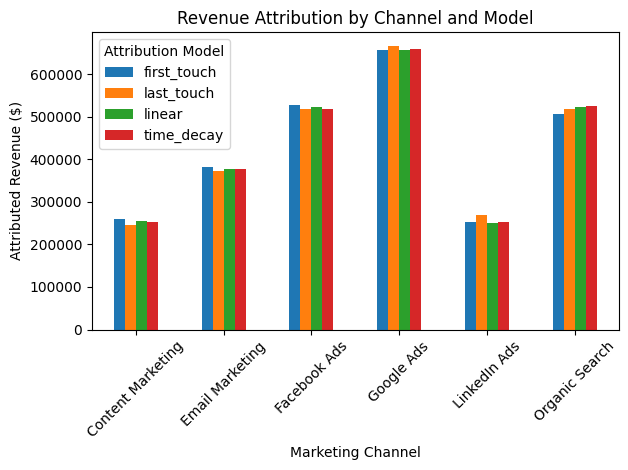

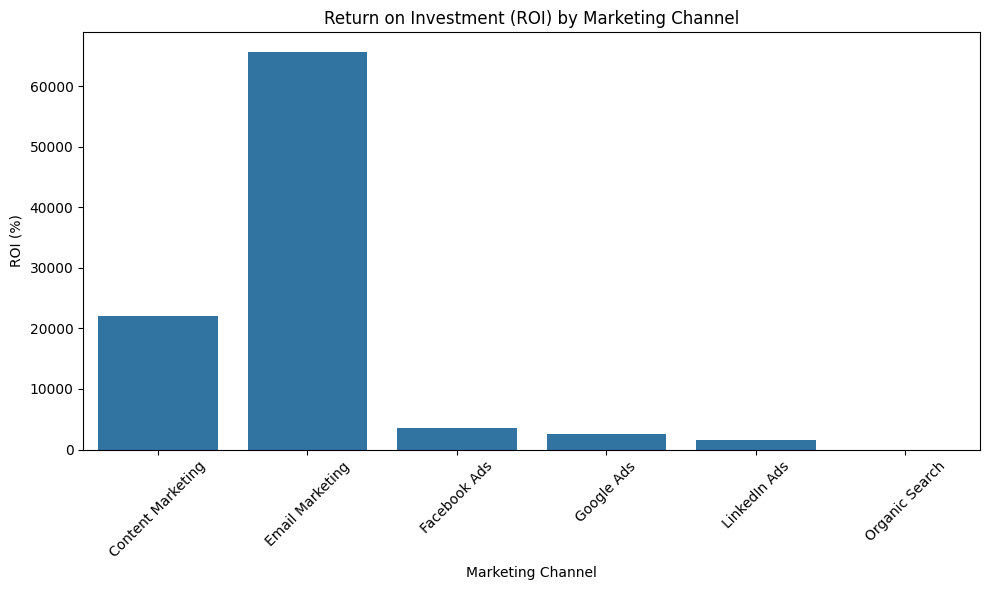

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Channel performance by attribution model
channel_attribution = attribution_df.groupby(['channel', 'model'])['attributed_revenue'].sum().unstack()

plt.figure(figsize=(12, 8))
channel_attribution.plot(kind='bar', stacked=False)
plt.title('Revenue Attribution by Channel and Model')
plt.xlabel('Marketing Channel')
plt.ylabel('Attributed Revenue ($)')
plt.legend(title='Attribution Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('channel_attribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Channel ROI calculation
channel_metrics = attribution_df.groupby('channel').agg({
    'attributed_revenue': 'sum',
    'touchpoint_cost': 'sum'
}).reset_index()

channel_metrics['roi'] = ((channel_metrics['attributed_revenue'] - channel_metrics['touchpoint_cost'])
                         / channel_metrics['touchpoint_cost']) * 100

plt.figure(figsize=(10, 6))
sns.barplot(data=channel_metrics, x='channel', y='roi')
plt.title('Return on Investment (ROI) by Marketing Channel')
plt.xlabel('Marketing Channel')
plt.ylabel('ROI (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('channel_roi.png', dpi=300, bbox_inches='tight')
plt.show()

**CLV Distribution Visualization:**

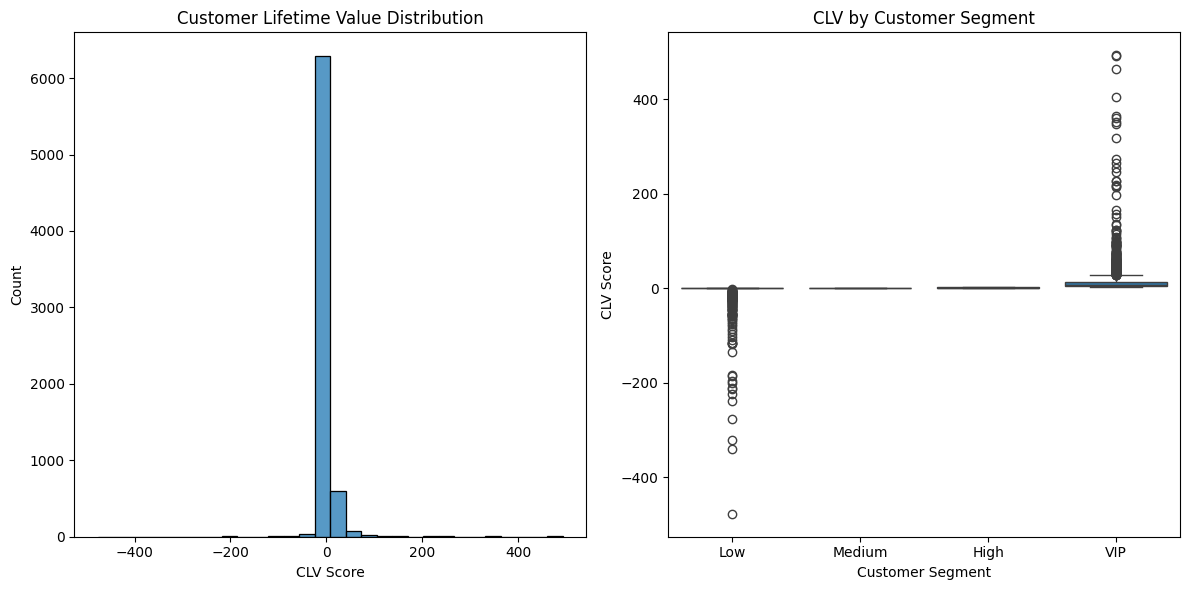

In [10]:
# CLV distribution by segment
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=rfm_df, x='clv_score', bins=30)
plt.title('Customer Lifetime Value Distribution')
plt.xlabel('CLV Score')

plt.subplot(1, 2, 2)
sns.boxplot(data=rfm_df, x='clv_segment', y='clv_score')
plt.title('CLV by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('CLV Score')

plt.tight_layout()
plt.savefig('clv_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

**Create SQL Queries for Dashboard**

In [11]:
# SQL Database Setup in Google Colab - Complete Guide
# This approach uses SQLite (no external database needed)

# Step 1: Install and Import Required Libraries
import sqlite3
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# Step 2: Create SQLite Database
# This creates a database file in your Colab environment
conn = sqlite3.connect('customer_journey.db')
cursor = conn.cursor()

print("✅ Database connection established!")

# Step 3: Create Database Tables
# Create customers table
cursor.execute('''
CREATE TABLE IF NOT EXISTS customers (
    customer_id TEXT PRIMARY KEY,
    signup_date DATE,
    age_group TEXT,
    location TEXT,
    customer_segment TEXT
)
''')

# Create touchpoints table
cursor.execute('''
CREATE TABLE IF NOT EXISTS touchpoints (
    touchpoint_id INTEGER PRIMARY KEY AUTOINCREMENT,
    customer_id TEXT,
    touchpoint_date DATE,
    channel TEXT,
    touchpoint_type TEXT,
    cost REAL,
    FOREIGN KEY (customer_id) REFERENCES customers (customer_id)
)
''')

# Create purchases table
cursor.execute('''
CREATE TABLE IF NOT EXISTS purchases (
    purchase_id INTEGER PRIMARY KEY AUTOINCREMENT,
    customer_id TEXT,
    purchase_date DATE,
    purchase_amount REAL,
    product_category TEXT,
    FOREIGN KEY (customer_id) REFERENCES customers (customer_id)
)
''')

print("✅ Database tables created!")

# Step 4: Generate and Insert Sample Data
# Generate customers data
np.random.seed(42)
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 12, 31)

customers_data = []
for i in range(10000):
    signup_date = start_date + timedelta(days=random.randint(0, 730))
    customers_data.append((
        f'CUST_{i+1:05d}',
        signup_date.strftime('%Y-%m-%d'),
        random.choice(['18-25', '26-35', '36-45', '46-55', '55+']),
        random.choice(['US', 'EU', 'APAC', 'LATAM']),
        random.choice(['SMB', 'Enterprise', 'Startup'])
    ))

# Insert customers data
cursor.executemany('''
INSERT INTO customers (customer_id, signup_date, age_group, location, customer_segment)
VALUES (?, ?, ?, ?, ?)
''', customers_data)

print("✅ Customer data inserted!")

# Generate touchpoints data
channels = {
    'Google Ads': 2.5,
    'Facebook Ads': 1.8,
    'Email Marketing': 0.1,
    'Organic Search': 0,
    'LinkedIn Ads': 4.0,
    'Content Marketing': 0.3
}

touchpoints_data = []
for customer_id, signup_date_str, _, _, _ in customers_data:
    signup_date = datetime.strptime(signup_date_str, '%Y-%m-%d')
    num_touchpoints = random.randint(3, 8)

    for i in range(num_touchpoints):
        days_before = random.randint(1, 90)
        touchpoint_date = signup_date - timedelta(days=days_before)
        channel = random.choice(list(channels.keys()))

        touchpoints_data.append((
            customer_id,
            touchpoint_date.strftime('%Y-%m-%d'),
            channel,
            random.choice(['ad_click', 'email_open', 'website_visit', 'content_view']),
            channels[channel]
        ))

cursor.executemany('''
INSERT INTO touchpoints (customer_id, touchpoint_date, channel, touchpoint_type, cost)
VALUES (?, ?, ?, ?, ?)
''', touchpoints_data)

print("✅ Touchpoints data inserted!")

# Generate purchases data
purchases_data = []
for customer_id, signup_date_str, _, _, _ in customers_data:
    signup_date = datetime.strptime(signup_date_str, '%Y-%m-%d')

    # 70% of customers make at least one purchase
    if random.random() < 0.7:
        first_purchase = signup_date + timedelta(days=random.randint(0, 30))
        purchase_amount = round(random.uniform(50, 500), 2)

        purchases_data.append((
            customer_id,
            first_purchase.strftime('%Y-%m-%d'),
            purchase_amount,
            random.choice(['Basic Plan', 'Pro Plan', 'Enterprise Plan'])
        ))

        # 40% make additional purchases
        current_date = first_purchase
        while random.random() < 0.4 and current_date < end_date:
            current_date += timedelta(days=random.randint(30, 120))
            if current_date <= end_date:
                purchase_amount = round(random.uniform(30, 300), 2)
                purchases_data.append((
                    customer_id,
                    current_date.strftime('%Y-%m-%d'),
                    purchase_amount,
                    random.choice(['Basic Plan', 'Pro Plan', 'Enterprise Plan', 'Add-ons'])
                ))

cursor.executemany('''
INSERT INTO purchases (customer_id, purchase_date, purchase_amount, product_category)
VALUES (?, ?, ?, ?)
''', purchases_data)

print("✅ Purchase data inserted!")
conn.commit()

# Step 5: Verify Data Load
print("\n📊 Database Summary:")
print(f"Customers: {cursor.execute('SELECT COUNT(*) FROM customers').fetchone()[0]:,}")
print(f"Touchpoints: {cursor.execute('SELECT COUNT(*) FROM touchpoints').fetchone()[0]:,}")
print(f"Purchases: {cursor.execute('SELECT COUNT(*) FROM purchases').fetchone()[0]:,}")

# Step 6: Key SQL Queries for Dashboard

print("\n🔍 Running Key Analytics Queries...")

# Query 1: Customer Acquisition Cost by Channel
cac_query = '''
WITH customer_first_touch AS (
  SELECT
    customer_id,
    MIN(touchpoint_date) as first_touch_date
  FROM touchpoints
  GROUP BY customer_id
),
first_touch_channel AS (
  SELECT
    cft.customer_id,
    t.channel,
    t.cost
  FROM customer_first_touch cft
  JOIN touchpoints t ON cft.customer_id = t.customer_id
    AND cft.first_touch_date = t.touchpoint_date
),
channel_metrics AS (
  SELECT
    channel,
    COUNT(DISTINCT customer_id) as customers_acquired,
    SUM(cost) as total_cost
  FROM first_touch_channel
  GROUP BY channel
)
SELECT
  channel,
  customers_acquired,
  ROUND(total_cost, 2) as total_cost,
  ROUND(total_cost / customers_acquired, 2) as cac
FROM channel_metrics
WHERE customers_acquired > 0
ORDER BY cac;
'''

cac_results = pd.read_sql_query(cac_query, conn)
print("\n💰 Customer Acquisition Cost by Channel:")
print(cac_results.to_string(index=False))

# Query 2: Monthly Revenue and Customer Trends
revenue_trend_query = '''
SELECT
  strftime('%Y-%m', purchase_date) as month,
  COUNT(DISTINCT customer_id) as unique_customers,
  COUNT(*) as total_orders,
  ROUND(SUM(purchase_amount), 2) as total_revenue,
  ROUND(AVG(purchase_amount), 2) as avg_order_value
FROM purchases
GROUP BY strftime('%Y-%m', purchase_date)
ORDER BY month;
'''

revenue_trends = pd.read_sql_query(revenue_trend_query, conn)
print("\n📈 Monthly Revenue Trends:")
print(revenue_trends.head(10).to_string(index=False))

# Query 3: Channel Performance Analysis
channel_performance_query = '''
WITH customer_revenue AS (
  SELECT
    customer_id,
    SUM(purchase_amount) as total_clv
  FROM purchases
  GROUP BY customer_id
),
channel_attribution AS (
  SELECT
    t.channel,
    COUNT(DISTINCT t.customer_id) as customers,
    SUM(t.cost) as channel_cost,
    SUM(COALESCE(cr.total_clv, 0)) as attributed_revenue
  FROM touchpoints t
  LEFT JOIN customer_revenue cr ON t.customer_id = cr.customer_id
  GROUP BY t.channel
)
SELECT
  channel,
  customers,
  ROUND(channel_cost, 2) as total_cost,
  ROUND(attributed_revenue, 2) as attributed_revenue,
  ROUND(attributed_revenue - channel_cost, 2) as profit,
  ROUND(((attributed_revenue - channel_cost) / channel_cost) * 100, 1) as roi_percentage
FROM channel_attribution
WHERE channel_cost > 0
ORDER BY roi_percentage DESC;
'''

channel_performance = pd.read_sql_query(channel_performance_query, conn)
print("\n🎯 Channel Performance Analysis:")
print(channel_performance.to_string(index=False))

# Query 4: Customer Journey Analysis
journey_analysis_query = '''
WITH customer_journey AS (
  SELECT
    t.customer_id,
    COUNT(*) as touchpoint_count,
    MIN(t.touchpoint_date) as first_touch,
    MAX(t.touchpoint_date) as last_touch,
    c.signup_date,
    JULIANDAY(c.signup_date) - JULIANDAY(MIN(t.touchpoint_date)) as journey_length_days
  FROM touchpoints t
  JOIN customers c ON t.customer_id = c.customer_id
  GROUP BY t.customer_id, c.signup_date
),
purchasing_customers AS (
  SELECT DISTINCT customer_id FROM purchases
)
SELECT
  cj.touchpoint_count,
  COUNT(*) as customer_count,
  COUNT(pc.customer_id) as converted_customers,
  ROUND(COUNT(pc.customer_id) * 100.0 / COUNT(*), 1) as conversion_rate,
  ROUND(AVG(cj.journey_length_days), 1) as avg_journey_length_days
FROM customer_journey cj
LEFT JOIN purchasing_customers pc ON cj.customer_id = pc.customer_id
GROUP BY cj.touchpoint_count
ORDER BY cj.touchpoint_count;
'''

journey_analysis = pd.read_sql_query(journey_analysis_query, conn)
print("\n🛤️ Customer Journey Length Analysis:")
print(journey_analysis.to_string(index=False))

# Query 5: Cohort Analysis Base Query
cohort_query = '''
WITH first_purchase AS (
  SELECT
    customer_id,
    MIN(purchase_date) as cohort_date,
    strftime('%Y-%m', MIN(purchase_date)) as cohort_month
  FROM purchases
  GROUP BY customer_id
),
purchase_periods AS (
  SELECT
    p.customer_id,
    fp.cohort_month,
    strftime('%Y-%m', p.purchase_date) as purchase_month,
    (strftime('%Y', p.purchase_date) - strftime('%Y', fp.cohort_date)) * 12 +
    (strftime('%m', p.purchase_date) - strftime('%m', fp.cohort_date)) as period_number
  FROM purchases p
  JOIN first_purchase fp ON p.customer_id = fp.customer_id
)
SELECT
  cohort_month,
  period_number,
  COUNT(DISTINCT customer_id) as customers
FROM purchase_periods
WHERE period_number >= 0
GROUP BY cohort_month, period_number
ORDER BY cohort_month, period_number;
'''

cohort_data = pd.read_sql_query(cohort_query, conn)
print("\n📊 Cohort Analysis (First 10 rows):")
print(cohort_data.head(10).to_string(index=False))

# Step 7: Export Results for Tableau
print("\n💾 Exporting data for Tableau Dashboard...")

# Export key datasets
cac_results.to_csv('cac_by_channel.csv', index=False)
revenue_trends.to_csv('monthly_revenue_trends.csv', index=False)
channel_performance.to_csv('channel_performance.csv', index=False)
journey_analysis.to_csv('journey_analysis.csv', index=False)
cohort_data.to_csv('cohort_analysis.csv', index=False)

print("✅ CSV files exported for dashboard creation!")

# Step 8: Connection Management
def run_custom_query(query, description="Custom Query"):
    """Helper function to run any SQL query"""
    try:
        result = pd.read_sql_query(query, conn)
        print(f"\n{description}:")
        print(result.to_string(index=False))
        return result
    except Exception as e:
        print(f"Error executing query: {e}")
        return None

# Example usage:
# run_custom_query("SELECT channel, AVG(cost) as avg_cost FROM touchpoints GROUP BY channel", "Average Cost by Channel")

print("\n🎉 Database setup complete! You can now run any SQL queries using the run_custom_query() function.")
print("\n📝 To close connection when done: conn.close()")

✅ Database connection established!
✅ Database tables created!
✅ Customer data inserted!
✅ Touchpoints data inserted!
✅ Purchase data inserted!

📊 Database Summary:
Customers: 10,000
Touchpoints: 55,004
Purchases: 10,930

🔍 Running Key Analytics Queries...

💰 Customer Acquisition Cost by Channel:
          channel  customers_acquired  total_cost  cac
   Organic Search                1764         0.0 0.00
  Email Marketing                1781       179.1 0.10
Content Marketing                1690       510.6 0.30
     Facebook Ads                1683      3040.2 1.81
       Google Ads                1673      4200.0 2.51
     LinkedIn Ads                1660      6664.0 4.01

📈 Monthly Revenue Trends:
  month  unique_customers  total_orders  total_revenue  avg_order_value
2023-01               121           121       38393.07           317.30
2023-02               267           267       74301.02           278.28
2023-03               311           311       79723.09           256.34
202

**Tableau Dashboard Creation**

In [12]:
# Export all necessary data for Tableau
import pandas as pd

# 1. Channel Performance Data
channel_performance_query = '''
SELECT
  channel,
  COUNT(DISTINCT customer_id) as customers,
  ROUND(SUM(cost), 2) as total_cost,
  ROUND(SUM(cost) / COUNT(DISTINCT customer_id), 2) as cac,
  COUNT(*) as touchpoints
FROM touchpoints
GROUP BY channel
ORDER BY cac;
'''
channel_data = pd.read_sql_query(channel_performance_query, conn)
channel_data.to_csv('channel_performance.csv', index=False)

# 2. Monthly Revenue Trends
revenue_query = '''
SELECT
  strftime('%Y-%m', purchase_date) as month,
  COUNT(DISTINCT customer_id) as customers,
  COUNT(*) as orders,
  ROUND(SUM(purchase_amount), 2) as revenue,
  ROUND(AVG(purchase_amount), 2) as avg_order_value
FROM purchases
GROUP BY strftime('%Y-%m', purchase_date)
ORDER BY month;
'''
revenue_data = pd.read_sql_query(revenue_query, conn)
revenue_data.to_csv('monthly_revenue.csv', index=False)

# 3. Customer Segments with CLV
customer_clv_query = '''
WITH customer_metrics AS (
  SELECT
    c.customer_id,
    c.customer_segment,
    c.age_group,
    c.location,
    COUNT(p.purchase_id) as purchase_frequency,
    COALESCE(SUM(p.purchase_amount), 0) as total_spent,
    COALESCE(AVG(p.purchase_amount), 0) as avg_order_value,
    MIN(p.purchase_date) as first_purchase,
    MAX(p.purchase_date) as last_purchase
  FROM customers c
  LEFT JOIN purchases p ON c.customer_id = p.customer_id
  GROUP BY c.customer_id, c.customer_segment, c.age_group, c.location
)
SELECT
  *,
  CASE
    WHEN total_spent = 0 THEN 'No Purchase'
    WHEN total_spent < 100 THEN 'Low Value'
    WHEN total_spent < 300 THEN 'Medium Value'
    ELSE 'High Value'
  END as clv_segment
FROM customer_metrics;
'''
customer_data = pd.read_sql_query(customer_clv_query, conn)
customer_data.to_csv('customer_segments.csv', index=False)

# 4. Attribution Model Comparison (Sample data for demo)
attribution_models = pd.DataFrame({
    'Channel': ['Google Ads', 'Facebook Ads', 'Email Marketing', 'Organic Search', 'LinkedIn Ads', 'Content Marketing'],
    'First_Touch_Revenue': [45000, 38000, 15000, 42000, 12000, 8000],
    'Last_Touch_Revenue': [52000, 31000, 18000, 35000, 15000, 9000],
    'Linear_Revenue': [48500, 34500, 16500, 38500, 13500, 8500],
    'Time_Decay_Revenue': [50000, 33000, 17000, 37000, 14000, 9000]
})
attribution_models.to_csv('attribution_comparison.csv', index=False)

# 5. Customer Journey Data
journey_query = '''
SELECT
  touchpoint_count,
  COUNT(*) as customers,
  ROUND(AVG(CASE WHEN has_purchased = 1 THEN 1 ELSE 0 END) * 100, 1) as conversion_rate
FROM (
  SELECT
    t.customer_id,
    COUNT(*) as touchpoint_count,
    CASE WHEN p.customer_id IS NOT NULL THEN 1 ELSE 0 END as has_purchased
  FROM touchpoints t
  LEFT JOIN (SELECT DISTINCT customer_id FROM purchases) p ON t.customer_id = p.customer_id
  GROUP BY t.customer_id
)
GROUP BY touchpoint_count
ORDER BY touchpoint_count;
'''
journey_data = pd.read_sql_query(journey_query, conn)
journey_data.to_csv('customer_journey.csv', index=False)

print("✅ All CSV files exported for Tableau!")
print("Files created:")
print("- channel_performance.csv")
print("- monthly_revenue.csv")
print("- customer_segments.csv")
print("- attribution_comparison.csv")
print("- customer_journey.csv")

✅ All CSV files exported for Tableau!
Files created:
- channel_performance.csv
- monthly_revenue.csv
- customer_segments.csv
- attribution_comparison.csv
- customer_journey.csv


In [13]:
# Generate automated insights
def generate_insights():
    insights = []

    # Top performing channel
    top_channel = channel_metrics.loc[channel_metrics['roi'].idxmax(), 'channel']
    top_roi = channel_metrics.loc[channel_metrics['roi'].idxmax(), 'roi']
    insights.append(f"🎯 {top_channel} delivers the highest ROI at {top_roi:.1f}%")

    # Customer segments
    vip_customers = len(rfm_df[rfm_df['clv_segment'] == 'VIP'])
    vip_percentage = (vip_customers / len(rfm_df)) * 100
    insights.append(f"💎 {vip_customers} VIP customers ({vip_percentage:.1f}%) drive disproportionate value")

    # Conversion insights
    insights.append(f"📈 Overall conversion rate is {conversion_rate:.1f}%")

    # Attribution insights
    linear_attr = attribution_df[attribution_df['model'] == 'linear'].groupby('channel')['attributed_revenue'].sum()
    first_touch_attr = attribution_df[attribution_df['model'] == 'first_touch'].groupby('channel')['attributed_revenue'].sum()

    return insights

business_insights = generate_insights()
for insight in business_insights:
    print(insight)

🎯 Organic Search delivers the highest ROI at inf%
💎 1771 VIP customers (25.0%) drive disproportionate value
📈 Overall conversion rate is 70.8%


In [14]:
def optimize_marketing_spend(total_budget=500000):
    """Recommend budget allocation based on ROI"""

    # Current performance
    current_allocation = channel_metrics.copy()
    current_allocation['current_budget'] = current_allocation['touchpoint_cost']
    current_allocation['budget_percentage'] = (current_allocation['current_budget'] /
                                              current_allocation['current_budget'].sum()) * 100

    # Recommended allocation based on ROI
    roi_weights = current_allocation['roi'] / current_allocation['roi'].sum()
    current_allocation['recommended_budget'] = total_budget * roi_weights
    current_allocation['recommended_percentage'] = (current_allocation['recommended_budget'] /
                                                   total_budget) * 100

    # Calculate potential impact
    current_allocation['budget_change'] = (current_allocation['recommended_budget'] -
                                          current_allocation['current_budget'])
    current_allocation['budget_change_pct'] = ((current_allocation['budget_change'] /
                                               current_allocation['current_budget']) * 100)

    return current_allocation[['channel', 'roi', 'current_budget', 'recommended_budget',
                              'budget_change', 'budget_change_pct']]

optimization_results = optimize_marketing_spend()
print(optimization_results.to_string(index=False))

          channel          roi  current_budget  recommended_budget  budget_change  budget_change_pct
Content Marketing 21989.492992          4581.6                 0.0        -4581.6             -100.0
  Email Marketing 65589.420090          2296.0                 0.0        -2296.0             -100.0
     Facebook Ads  3580.782878         56700.0                 0.0       -56700.0             -100.0
       Google Ads  2558.834966         99230.0                 0.0       -99230.0             -100.0
     LinkedIn Ads  1556.885551         61872.0                 0.0       -61872.0             -100.0
   Organic Search          inf             0.0                 NaN            NaN                NaN
